### Tutorial: Sensing Cox Process [sensepy]
In this tutorial we are exploring:
 1. how to fit Cox process using positive basis
 2. sample from it
 3. set up Thompson sampling sensing algorithm


In [1]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
from sensepy.benchmarks.bels.bels_problem import BeilschmiediaProblem

2024-10-05 17:03:53.800871: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 17:03:53.805985: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 17:03:53.822238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 17:03:53.844384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 17:03:53.851737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 17:03:53.875976: I tensorflow/core/platform/cpu_feature_gu


#### Setting up a Benchmark 

In [2]:
benchmark = BeilschmiediaProblem()
# load data to the benchmark 
benchmark.load_data(prefix = '../benchmarks/data/')
# fit the benchmark 
benchmark.fit_model()

# returns a poisson process file that we can sample from  
process = benchmark.return_process()

# domain of the process
D = benchmark.D

# sample initial data over the whole domain
dt = 1.
obs = process.sample(D, dt = dt)

# data must be specified in the following format if fitted in a custom manner
data = [(D, obs, dt)]

Precomputing phis.
Precomputation finished.
loading begins.
data loaded.
Number of events: torch.Size([3604, 2])
Precomputing phis.
Precomputation finished.
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Maximum:  tensor(1.9345, dtype=torch.float64) minimum tensor(0.1002, dtype=torch.float64)
Process created.


#### Demonstration of fitting a Cox Process

In [3]:
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1., 1.], [-1, 1]]).double())

# quadtree with [-1,1], levels signifies number of splits
hs2d = HierarchicalBorelSets(d=2, interval=[(-1, 1), (-1, 1)], levels=5)

# kernel function from the benchmark 
k = benchmark.kernel

# creating estimator - the first argument is Poisson process object if existing 
m = 20  # number of basis functions 
b = 0.1 # minimal value of the rate function 
B = 10e10 # maximal value of the rate function
steps = 100 # number of Langevin steps for sampling
estimator = PoissonRateEstimator(None, hs2d, d=2,
                                  kernel_object=k, B=B, b=b,
                                  m=m, jitter=1e-5,
                                  steps = steps, opt='torch', offset = 0.1)

Precomputing phis.
Precomputation finished.


In [4]:
# load data in the above format
estimator.load_data(data)
# fit the Cox process by calculating MAP
estimator.fit_gp()

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


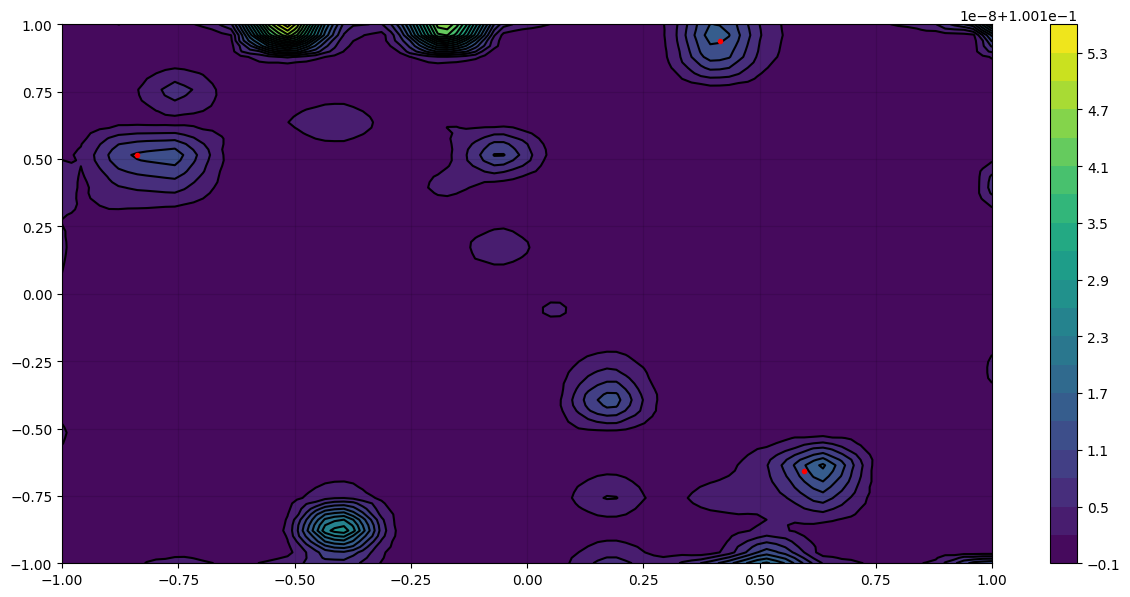

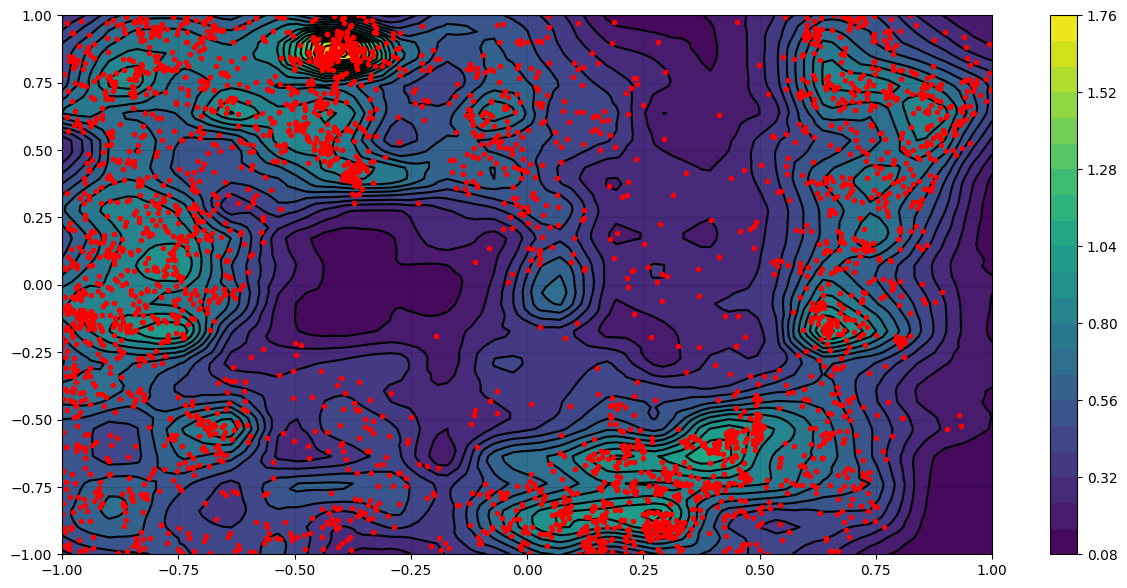

In [5]:
# Plotting the fitted Map along with ground truth
benchmark.plot_mean(estimator)
benchmark.plot()

#### Demonstration of sampling from a Cox Process (prior)

Precomputing phis.
Precomputation finished.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Sampling started.
Sampling finished.
Sampling started.
Sampling finished.
Sampling started.
Sampling finished.
Sampling started.
Sampling finished.


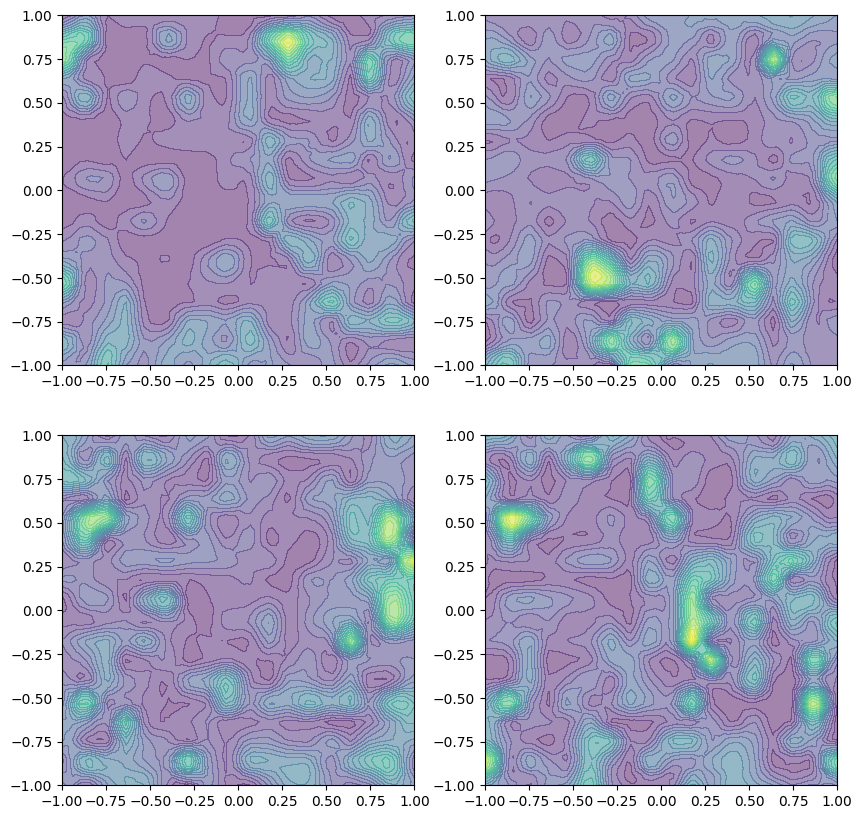

In [6]:
# skim the data to only two data points
initial_data = [(D,obs[0:2,:],dt)]
estimator_new = PoissonRateEstimator(None, hs2d, d=2,
                                  kernel_object=k, B=B, b=b,
                                  m=m, jitter=1e-5,
                                  steps = steps, opt='torch', offset = 0.1)
estimator_new.load_data(initial_data)
estimator_new.fit_gp()

xtest = D.return_discretization(40)
xx = xtest[:,0].numpy()
yy = xtest[:,1].numpy()
grid_x, grid_y = np.mgrid[min(xx):max(xx):100j, min(yy):max(yy):100j]

steps = 10
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(2*5, 2*5))
for i in range(4):
    estimator_new.sample(steps = steps)
    f = estimator_new.sample_path_points(xtest)
    grid_z_f = griddata((xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method='linear')
    cs = ax[i//2,i%2].contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
plt.show()

#### Sensing 
Now we will set us a Thompson sampling sensing algorithm to maximize number of captured events. 

In [7]:
# create a Poisson process with the estimated rate
rate = lambda x: estimator.mean_rate_points(x)
rate_volume = lambda S: estimator.mean_set(S)

xtest = D.return_discretization(40)
vals = rate(xtest)

b = torch.min(vals)
B = torch.max(vals)

process = PoissonPointProcess(d=2, B=B, b=b, rate=rate, rate_volume=rate_volume)



In [8]:
# generate actions
action_levels = 4
actions = hs2d.get_sets_level(action_levels)

# cost function: just using volume of the set 
w = lambda s: s.volume()

Bandit = CaptureThompson(process, estimator, w, initial_data=initial_data, dt=dt)
cost, event_loc, action, action_index = Bandit.step(actions, verbose=True, points=True)

/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Sampling started.
Sampling finished.
Scores: tensor([  2.8292,   7.4897,   7.8701,   9.9751,   6.3880,   7.6526,   7.4590,
         13.2355,  11.2702,  11.9752,   8.0392,  20.6325,  12.9593,  17.2298,
         29.4568,  11.2760,  74.4018, 158.4843,  22.4914,  51.0328,  73.8852,
         45.1557,  42.8344,  95.0933,   9.7762,  14.0203,   7.3989,  15.7179,
         20.5897,  46.5014,  25.6908,  19.1025,  10.4068,  32.0706,  15.1558,
         15.0214,  32.7378,  40.8552,  13.6293,   9.9850,   6.1158,   4.7545,
         21.1590,  22.1273,  11.7856,   2.4703,  22.4788,  21.7455,  17.3718,
          4.0100,   7.2906,   5.6027,  13.1036,  14.8740,  14.9473,  17.0938,
          8.5600,  11.1513,  20.1738,  17.4706,  21.3816,  15.9326,  13.5016,
         12.3302], dtype=torch.float64)
Sensing: [tensor([[-1.0000, -0.7500],
        [ 0.2500,  0.5000]])]
Total events so far: 2


In [ ]:
T = 5
for t in range(T):
    cost, event_loc, action, action_index = Bandit.step(actions, verbose=True, points=True)
    print (t, cost)

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Sampling started.
Sampling finished.
Scores: tensor([ 8.7426, 11.0536,  5.5009,  3.0630,  3.7942,  3.3762,  6.9281,  4.4040,
        10.9733,  6.7852,  3.8233,  3.8474,  5.8691,  5.1696,  2.2714,  6.9550,
         1.7646,  2.2354,  3.3836,  2.3742,  1.6230,  8.6252,  1.4658,  4.7610,
         9.5262,  2.6879,  4.8803,  3.2637,  2.5103,  6.1914,  2.9559,  2.9191,
         9.3082,  5.5703,  5.4120,  7.3496,  2.0171,  4.9517,  5.4026,  6.3682,
        14.8731, 33.1461, 13.1918, 14.3601,  9.5600, 15.2050,  9.9063, 12.7267,
         3.8324,  8.3536,  6.6290, 15.4230,  7.9278,  9.6723, 22.1439, 14.2613,
        10.5659,  8.8354, 13.2060, 12.3477, 11.9301,  7.1330, 10.0536,  9.7323],
       dtype=torch.float64)
Sensing: [tensor([[ 0.5000,  0.7500],
        [-0.7500, -0.5000]])]
Total events so far: 2
0 tensor(0.0625)
